In [2]:
import pandas as pd

df = pd.read_csv('traffic_weather.csv')
print(df.columns)
print(len(df))

Index(['Intersection Name', 'Month', 'Day', 'Year', 'Hour', 'Day of Week',
       'Holiday', 'Direction', 'Speed', 'Volume', 'Full Date', 'date', 'tavg',
       'tmin', 'tmax', 'prcp', 'snow', 'wspd', 'temperature'],
      dtype='object')
229939


In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import torch
from torch.utils.data import DataLoader, TensorDataset

# Copy the dataframe to preserve the original
df_copy3 = df.copy()

# Drop 'Full Date' and other irrelevant columns
df_copy3 = df_copy3.drop(columns=['Full Date', 'date', 'tmin', 'tmax', 'tavg'])

# Handle missing values in 'Speed' (use hourly average)
hourly_avg_speed = df_copy3.groupby('Hour')['Speed'].transform('mean')
df_copy3['Speed'] = df_copy3['Speed'].fillna(hourly_avg_speed)

# Handle missing values in other columns
numerical_cols = ['Speed', 'temperature', 'prcp', 'snow', 'wspd']
df_copy3[numerical_cols] = df_copy3[numerical_cols].fillna(df_copy3[numerical_cols].mean())  # Impute with mean

categorical_cols = ['Intersection Name', 'Direction', 'Hour', 'Year', 'Month', 'Day']
df_copy3[categorical_cols] = df_copy3[categorical_cols].fillna('Unknown')  # Impute categorical with 'Unknown'

# One-hot encode categorical columns
df_copy3 = pd.get_dummies(df_copy3, columns=categorical_cols, drop_first=True)

# Standardize numerical columns
scaler = StandardScaler()
df_copy3[numerical_cols] = scaler.fit_transform(df_copy3[numerical_cols])

# Separate features and target variable
X = df_copy3.drop(columns=['Volume'])
y = df_copy3['Volume']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


# Check data types before conversion to tensor
print(X_train.dtypes)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Create DataLoader for batching
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

val_data = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

test_data = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Check if data preprocessing is complete
print("Data preprocessing complete!")


Day of Week      int64
Holiday          int64
Speed          float64
prcp           float64
snow           float64
                ...   
Day_27           uint8
Day_28           uint8
Day_29           uint8
Day_30           uint8
Day_31           uint8
Length: 81, dtype: object
Data preprocessing complete!


In [14]:
import torch.nn as nn

class MyModule(nn.Module):
    def __init__(self, inp_size, hidden_sizes, nonlin, num_classes=1):
        super(MyModule, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(inp_size, hidden_sizes[0]),
            nonlin,
            *[
                layer
                for i in range(len(hidden_sizes) - 1)
                for layer in (
                    nn.Linear(hidden_sizes[i], hidden_sizes[i + 1]),
                    nonlin,
                )
            ],
            nn.Linear(hidden_sizes[-1], num_classes)  # Adjust output layer
        )
    def forward(self, x):
        return self.layers(x)


In [15]:
def train(model, X_train, y_train, X_valid, y_valid, n_epochs, batch_size, optimizer, loss_fn):
    import torch
    from torch.utils.data import DataLoader, TensorDataset

    # Convert data to tensors
    X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
    X_valid_tensor = torch.tensor(X_valid.values, dtype=torch.float32)
    y_valid_tensor = torch.tensor(y_valid.values, dtype=torch.float32).view(-1, 1)

    # Create DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Initialize variables to track best model
    best_weights = None
    best_mse = float('inf')
    train_history = []
    valid_history = []

    # Training loop
    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0

        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            predictions = model(batch_X)
            loss = loss_fn(predictions, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Evaluate on validation data
        model.eval()
        with torch.no_grad():
            val_predictions = model(X_valid_tensor)
            val_loss = loss_fn(val_predictions, y_valid_tensor).item()

        # Track the best model weights
        if val_loss < best_mse:
            best_mse = val_loss
            best_weights = model.state_dict()

        train_history.append(epoch_loss / len(train_loader))
        valid_history.append(val_loss)

        # Print progress
        print(f"Epoch [{epoch + 1}/{n_epochs}], Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}")

    return best_weights, train_history, valid_history, best_mse


In [16]:
# Evaluate Function

import torch
import torch.nn.functional as F
from sklearn.metrics import r2_score
import numpy as np

def eval(model, X, y):
    model.eval()
    # Convert inputs to numpy arrays and then to tensors
    X_tensor = torch.tensor(X.values, dtype=torch.float32)  # Convert DataFrame to numpy and then tensor
    y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)  # Convert to tensor
    
    with torch.no_grad():
        y_pred = model(X_tensor)
        mse = F.mse_loss(y_pred, y_tensor).item()
        rmse = np.sqrt(mse)  # Calculate RMSE from MSE
        r2 = r2_score(y, y_pred.numpy())  # Convert predictions to numpy for sklearn
    
    return mse, rmse, r2

    return mse, r2, rmse



In [17]:
from sklearn.model_selection import ParameterGrid
import copy

# Define parameter grid
param_grid = {
    'inp_size': [X_train.shape[1]],  # Number of features after preprocessing
    'hidden_sizes': [[16, 8], [32, 16, 8]],
    'lr': [0.001, 0.01],
    'n_epochs': [20, 30],
    'batch_size': [64, 128]
}

best_model = None
best_weights = None
best_mse = float('inf')
best_params = None

for params in ParameterGrid(param_grid):
    # Initialize model (assuming a custom model class 'MyModule' is defined elsewhere)
    model = MyModule(
        inp_size=params['inp_size'],
        hidden_sizes=params['hidden_sizes'],
        nonlin=nn.ReLU()
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
    loss_fn = nn.MSELoss()

    # Train the model and get results
    current_weights, train_history, valid_history, current_mse = train(
        model, 
        X_train, 
        y_train, 
        X_val, 
        y_val, 
        params['n_epochs'], 
        params['batch_size'], 
        optimizer, 
        loss_fn
    )

    # Check if this model is the best so far
    if current_mse < best_mse:
        best_mse = current_mse
        best_model = copy.deepcopy(model)  # Save the entire model
        best_weights = copy.deepcopy(current_weights)  # Save the best weights
        best_params = params  # Save the best hyperparameters

print(f"Best MSE: {best_mse}")
print(f"Best Params: {best_params}")


Epoch [1/20], Training Loss: 316959909.6895, Validation Loss: 57160.5898
Epoch [2/20], Training Loss: 124549805.6875, Validation Loss: 45644.8555
Epoch [3/20], Training Loss: 106592940.8271, Validation Loss: 41261.0391
Epoch [4/20], Training Loss: 99409391.5947, Validation Loss: 39618.5508
Epoch [5/20], Training Loss: 96716458.3135, Validation Loss: 38885.0430
Epoch [6/20], Training Loss: 95361738.1523, Validation Loss: 38442.6797
Epoch [7/20], Training Loss: 94286599.4854, Validation Loss: 38000.7500
Epoch [8/20], Training Loss: 93148404.7285, Validation Loss: 37550.1992
Epoch [9/20], Training Loss: 91873244.3657, Validation Loss: 37030.5430
Epoch [10/20], Training Loss: 89932419.1162, Validation Loss: 35900.6484
Epoch [11/20], Training Loss: 86579535.2520, Validation Loss: 34571.6016
Epoch [12/20], Training Loss: 82974600.9678, Validation Loss: 33208.2656
Epoch [13/20], Training Loss: 79498284.6904, Validation Loss: 31898.9648
Epoch [14/20], Training Loss: 76561408.2651, Validation L

In [18]:
# Evaluate on test set
test_mse, test_rmse, test_r2 = eval(best_model, X_test, y_test)

# Print the results
print(f"Test MSE: {test_mse}")
print(f"Test RMSE: {test_rmse}")
print(f"Test R2: {test_r2}")



Test MSE: 6572.36962890625
Test RMSE: 81.07015251562224
Test R2: 0.957833371777863


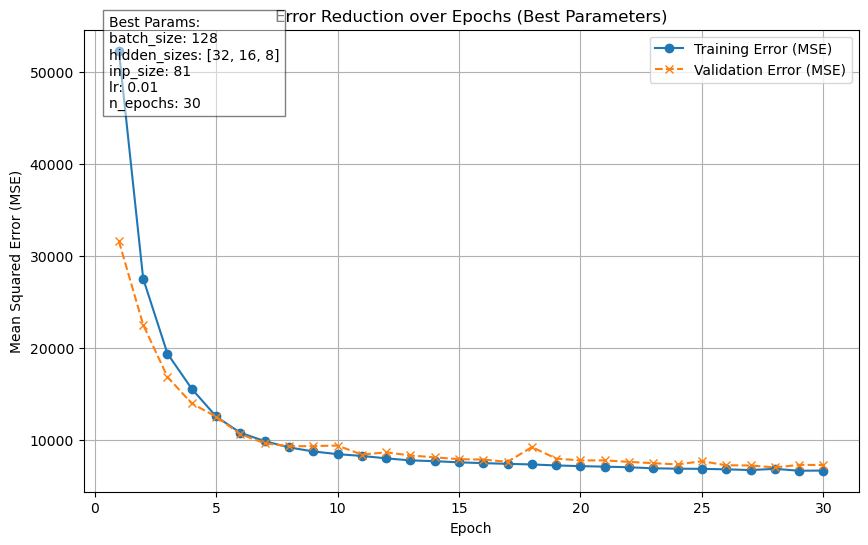

In [19]:
import matplotlib.pyplot as plt

# Assuming train_history and valid_history are lists of errors (MSE) over epochs
def plot_training_validation_history(train_history, valid_history, best_params):
    epochs = range(1, len(train_history) + 1)  # Epoch numbers

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_history, label='Training Error (MSE)', marker='o', linestyle='-')
    plt.plot(epochs, valid_history, label='Validation Error (MSE)', marker='x', linestyle='--')

    # Add title and labels
    plt.title("Error Reduction over Epochs (Best Parameters)")
    plt.xlabel("Epoch")
    plt.ylabel("Mean Squared Error (MSE)")
    plt.legend()

    # Add grid for better readability
    plt.grid(True)

    # Annotate best parameters
    best_params_text = '\n'.join([f"{key}: {val}" for key, val in best_params.items()])
    plt.gcf().text(0.15, 0.75, f"Best Params:\n{best_params_text}", fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

    # Show the plot
    plt.show()

# Call the function with best parameters and their respective histories
plot_training_validation_history(train_history, valid_history, best_params)


In [20]:
import numpy as np
from sklearn.metrics import mean_squared_error

def permutation_importance(model, X, y):
    model.eval()
    baseline_preds = model(torch.tensor(X.values, dtype=torch.float32)).detach().numpy()
    baseline_mse = mean_squared_error(y, baseline_preds)

    importances = []
    for col in X.columns:
        X_permuted = X.copy()
        X_permuted[col] = np.random.permutation(X_permuted[col])
        permuted_preds = model(torch.tensor(X_permuted.values, dtype=torch.float32)).detach().numpy()
        permuted_mse = mean_squared_error(y, permuted_preds)
        importances.append(permuted_mse - baseline_mse)

    # Return feature names and their importance
    return dict(zip(X.columns, importances))

# Calculate permutation importance
feature_importances = permutation_importance(best_model, X_test, y_test)
sorted_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)

print("Feature Importances (sorted):")
for feature, importance in sorted_importances:
    print(f"{feature}: {importance:.4f}")


Feature Importances (sorted):
Intersection Name_LAMARCOLLIER: 109346.7396
Intersection Name_BurnetRutland: 76785.4204
Intersection Name_BURNETPALM WAY: 74526.6227
Intersection Name_CONGRESSBARTON SPRINGS: 65174.6307
Hour_17: 56575.3078
Hour_18: 45832.7656
Hour_16: 43577.8874
Hour_8: 39382.1965
Hour_13: 34698.7788
Hour_15: 34438.4962
Day of Week: 32966.3417
Hour_12: 31547.0947
Hour_14: 30972.7057
Hour_9: 29625.2626
Direction_SB: 28337.6038
Hour_19: 26769.0116
Intersection Name_CongressJohanna: 25595.1401
Hour_11: 20089.0877
Year_2020: 18777.1969
Hour_7: 17232.8440
Hour_10: 16729.3549
Speed: 13275.6370
Hour_20: 9951.8712
Year_2021: 9580.8782
Hour_3: 8683.0657
Hour_4: 8574.2217
Hour_5: 8489.1475
Hour_2: 6594.1087
Hour_1: 6491.9074
Hour_21: 5281.3682
Hour_6: 4786.3251
Hour_22: 2601.3069
Holiday: 2438.7137
Year_2019: 2142.2702
Hour_23: 1715.9389
Year_2018: 1655.5909
Month_7: 883.3697
Month_4: 879.0957
Month_12: 778.3871
temperature: 773.5821
Month_10: 717.7690
Month_11: 550.3221
Month_6: 52